In [2]:
import torch
import torch.nn as nn
import numpy as np
import pickle
from umap import UMAP
from sklearn.cluster import KMeans
import plotly.express as px
from tqdm import tqdm
import plotly.io as pio

# Use your GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pio.renderers.default = "browser"

# ---- Model Definition ----
class AttentionNullModel(nn.Module):
    def __init__(self, vit_dim, neuron_embed_dim, num_neurons, attention_dim, mlp_dim=128):
        super().__init__()
        self.neuron_embedding = nn.Embedding(num_neurons, neuron_embed_dim)
        self.input_proj = nn.Linear(vit_dim + neuron_embed_dim, attention_dim)
        self.attn = nn.MultiheadAttention(embed_dim=attention_dim, num_heads=1, batch_first=True)
        self.mlp = nn.Sequential(
            nn.LayerNorm(attention_dim),
            nn.Linear(attention_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, attention_dim)
        )
        self.out = nn.Linear(attention_dim, 1)

    def forward(self, image_embedding, neuron_idx):
        neuron_emb = self.neuron_embedding(neuron_idx)
        x = torch.cat([image_embedding, neuron_emb], dim=-1)
        x = self.input_proj(x).unsqueeze(1)
        attn_out, _ = self.attn(x, x, x)
        mlp_out = self.mlp(attn_out)
        final = attn_out + mlp_out
        return self.out(final.squeeze(1))  # (B,)

# ---- Paths ----
model_path = "/home/maria/LuckyMouse2/saved_models/fold_0/model.pt"
embeddings_path = "/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/google_vit-base-patch16-224_embeddings_softmax.pkl"

# ---- Load ViT stimulus embeddings ----
with open(embeddings_path, "rb") as f:
    vit_data = pickle.load(f)['natural_scenes']
vit_embeddings = torch.tensor(vit_data, dtype=torch.float32).to(device)  # (num_images, vit_dim)

# ---- Load Model ----
model = AttentionNullModel(
    vit_dim=1000,
    neuron_embed_dim=64,
    num_neurons=39209,
    attention_dim=128
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ---- Get Neuron Embeddings ----
with torch.no_grad():
    neuron_embeddings = model.neuron_embedding.weight.cpu().numpy()  # (39209, 64)

# ---- UMAP + KMeans ----
umap = UMAP(n_components=3, random_state=42)
neuron_embeddings_umap = umap.fit_transform(neuron_embeddings)

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(neuron_embeddings_umap)

# ---- Compute Log-likelihood Proxy (Negative MSE) per neuron ----
log_likelihoods = np.zeros(model.neuron_embedding.num_embeddings)
batch_size = 512

with torch.no_grad():
    for neuron_id in tqdm(range(model.neuron_embedding.num_embeddings), desc="Computing log-likelihoods"):
        preds = []
        for i in range(0, vit_embeddings.shape[0], batch_size):
            batch_images = vit_embeddings[i:i+batch_size]
            batch_neuron_idx = torch.full((batch_images.size(0),), neuron_id, dtype=torch.long).to(device)
            out = model(batch_images, batch_neuron_idx)
            preds.append(out.cpu())

        preds = torch.cat(preds)
        mse = torch.nn.functional.mse_loss(preds, torch.zeros_like(preds), reduction='mean')
        log_likelihoods[neuron_id] = -mse.item()

# ---- Plot in UMAP space ----
fig = px.scatter_3d(
    x=neuron_embeddings_umap[:, 0],
    y=neuron_embeddings_umap[:, 1],
    z=neuron_embeddings_umap[:, 2],
    color=log_likelihoods,
    title="Neuron Embeddings (UMAP) Colored by Log-Likelihood",
    labels={"x": "UMAP-1", "y": "UMAP-2", "z": "UMAP-3"},
    color_continuous_scale="Viridis"
)
fig.update_traces(marker=dict(size=2))
fig.show()


/home/maria/global_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

Computing log-likelihoods: 100%|██████████| 39209/39209 [00:30<00:00, 1301.90it/s]


In [4]:
import torch
import torch.nn as nn
import numpy as np
import pickle
from umap import UMAP
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import plotly.io as pio

# Use browser for plots
pio.renderers.default = "browser"

# ---- Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Model Definition ----
class AttentionNullModel(nn.Module):
    def __init__(self, vit_dim, neuron_embed_dim, num_neurons, attention_dim, mlp_dim=128):
        super().__init__()
        self.neuron_embedding = nn.Embedding(num_neurons, neuron_embed_dim)
        self.input_proj = nn.Linear(vit_dim + neuron_embed_dim, attention_dim)
        self.attn = nn.MultiheadAttention(embed_dim=attention_dim, num_heads=1, batch_first=True)
        self.mlp = nn.Sequential(
            nn.LayerNorm(attention_dim),
            nn.Linear(attention_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, attention_dim)
        )
        self.out = nn.Linear(attention_dim, 1)

    def forward(self, image_embedding, neuron_idx):
        neuron_emb = self.neuron_embedding(neuron_idx)
        x = torch.cat([image_embedding, neuron_emb], dim=-1)
        x = self.input_proj(x).unsqueeze(1)
        attn_out, _ = self.attn(x, x, x)
        mlp_out = self.mlp(attn_out)
        final = attn_out + mlp_out
        return self.out(final.squeeze(1))  # (B,)

# ---- Paths ----
model_path = "/home/maria/LuckyMouse2/saved_models/fold_0/model.pt"
embeddings_path = "/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/google_vit-base-patch16-224_embeddings_softmax.pkl"

# ---- Load ViT stimulus embeddings ----
with open(embeddings_path, "rb") as f:
    vit_data = pickle.load(f)['natural_scenes']
vit_embeddings = torch.tensor(vit_data, dtype=torch.float32).to(device)

# ---- Load Model ----
model = AttentionNullModel(
    vit_dim=1000,
    neuron_embed_dim=64,
    num_neurons=39209,
    attention_dim=128
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ---- Get Neuron Embeddings ----
with torch.no_grad():
    neuron_embeddings = model.neuron_embedding.weight.cpu().numpy()  # (39209, 64)

# ---- UMAP + KMeans ----
umap = UMAP(n_components=3, random_state=42)
neuron_embeddings_umap = umap.fit_transform(neuron_embeddings)

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(neuron_embeddings_umap)

# ---- Compute average predicted probability per neuron ----
average_probs = np.zeros(model.neuron_embedding.num_embeddings)
batch_size = 512
sigmoid = torch.nn.Sigmoid()

with torch.no_grad():
    for neuron_id in tqdm(range(model.neuron_embedding.num_embeddings), desc="Computing average probabilities"):
        probs = []
        for i in range(0, vit_embeddings.size(0), batch_size):
            batch_images = vit_embeddings[i:i+batch_size]
            batch_neuron_idx = torch.full((batch_images.size(0),), neuron_id, dtype=torch.long).to(device)
            out = model(batch_images, batch_neuron_idx)
            probs.append(sigmoid(out).cpu())

        probs = torch.cat(probs)
        average_probs[neuron_id] = probs.mean().item()

# ---- UMAP 3D Plot colored by average probability ----
fig_3d = px.scatter_3d(
    x=neuron_embeddings_umap[:, 0],
    y=neuron_embeddings_umap[:, 1],
    z=neuron_embeddings_umap[:, 2],
    color=average_probs,
    title="Neuron Embeddings (UMAP) Colored by Avg Probability",
    labels={"x": "UMAP-1", "y": "UMAP-2", "z": "UMAP-3"},
    color_continuous_scale="Viridis"
)
fig_3d.update_traces(marker=dict(size=2))
fig_3d.show()

# ---- Compute average probability per cluster ----
cluster_avg_probs = []
for c in range(kmeans.n_clusters):
    cluster_avg_probs.append(average_probs[cluster_labels == c].mean())

# ---- Bar Chart of Avg Probability per Cluster ----
fig_bar = go.Figure()
fig_bar.add_trace(go.Bar(
    x=[f"Cluster {i}" for i in range(kmeans.n_clusters)],
    y=cluster_avg_probs,
    marker_color='indigo'
))
fig_bar.update_layout(
    title="Average Predicted Probability per Neuron Cluster",
    xaxis_title="Cluster",
    yaxis_title="Average Probability",
    yaxis_range=[0, 1],
)
fig_bar.show()


/home/maria/global_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

Computing average probabilities: 100%|██████████| 39209/39209 [00:22<00:00, 1746.09it/s]


In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def plot_probability_histograms_by_cluster(average_probs, cluster_labels, num_bins=30):
    """
    Plots one histogram per cluster showing the distribution of average probabilities.
    
    Parameters:
        average_probs (np.ndarray): Array of shape (n_neurons,) with average probabilities.
        cluster_labels (np.ndarray): Array of shape (n_neurons,) with KMeans cluster labels.
        num_bins (int): Number of histogram bins per plot.
    """
    unique_clusters = np.unique(cluster_labels)
    fig = make_subplots(
        rows=1, cols=len(unique_clusters),
        subplot_titles=[f"Cluster {c}" for c in unique_clusters],
        shared_yaxes=True
    )

    for i, c in enumerate(unique_clusters):
        cluster_probs = average_probs[cluster_labels == c]
        fig.add_trace(
            go.Histogram(
                x=cluster_probs,
                nbinsx=num_bins,
                name=f"Cluster {c}",
                marker=dict(color=px.colors.qualitative.Plotly[i % 10])
            ),
            row=1, col=i+1
        )

    fig.update_layout(
        title_text="Histogram of Average Predicted Probabilities per Cluster",
        showlegend=False,
        height=400,
        width=300 * len(unique_clusters),
        bargap=0.1,
        xaxis_title="Avg Probability"
    )

    fig.show()

plot_probability_histograms_by_cluster(average_probs, cluster_labels)

(array([3.174739e+06, 8.160220e+05, 3.824040e+05, 9.883300e+04,
        7.378400e+04, 3.544300e+04, 1.337800e+04, 8.629000e+03,
        7.987000e+03, 3.471000e+03, 3.565000e+03, 2.471000e+03,
        1.207000e+03, 1.391000e+03, 7.870000e+02, 6.010000e+02,
        7.320000e+02, 3.980000e+02, 4.500000e+02, 3.700000e+02]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

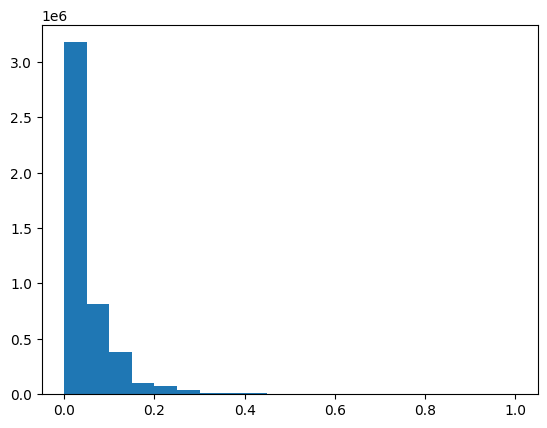

In [11]:
dat=np.load('/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/hybrid_neural_responses_reduced.npy')
dat=dat/50
import matplotlib.pyplot as plt
plt.hist(dat.flatten(),bins=20)

In [16]:
# Sample 1000 random neurons
np.random.seed(42)
num_neurons=39209
num_images=118
subset_neuron_ids = np.random.choice(num_neurons, size=1000, replace=False)
num_subset = len(subset_neuron_ids)

predicted_probs_subset = np.zeros((num_subset, num_images), dtype=np.float32)


with torch.no_grad():
    for j, neuron_id in enumerate(tqdm(subset_neuron_ids, desc="Subset neuron predictions")):
        neuron_probs = []
        for i in range(0, num_images, batch_size):
            image_batch = vit_embeddings[i:i+batch_size]
            neuron_idx_batch = torch.full((image_batch.shape[0],), neuron_id, dtype=torch.long).to(vit_embeddings.device)
            logits = model(image_batch, neuron_idx_batch)
            probs = sigmoid(logits).squeeze().cpu().numpy()
            neuron_probs.append(probs)
        predicted_probs_subset[j] = np.concatenate(neuron_probs)


Subset neuron predictions: 100%|██████████| 1000/1000 [00:00<00:00, 3422.23it/s]


In [ ]:
# Load real data
dat = np.load('/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/hybrid_neural_responses_reduced.npy')
empirical_probs = dat / 50

# Extract same subset
empirical_subset = empirical_probs[subset_neuron_ids]

# Flatten and plot calibration
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

y_true = empirical_subset.flatten()
y_pred = predicted_probs_subset.flatten()
valid = np.isfinite(y_true) & np.isfinite(y_pred)

prob_true, prob_pred = calibration_curve(y_true[valid], y_pred[valid], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Model calibration')
plt.plot([0, 1], [0, 1], '--', label='Perfect calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.title("Calibration Plot (Random 1000 Neurons)")
plt.legend()
plt.grid(True)
plt.show()


ValueError: y_true takes value in {0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

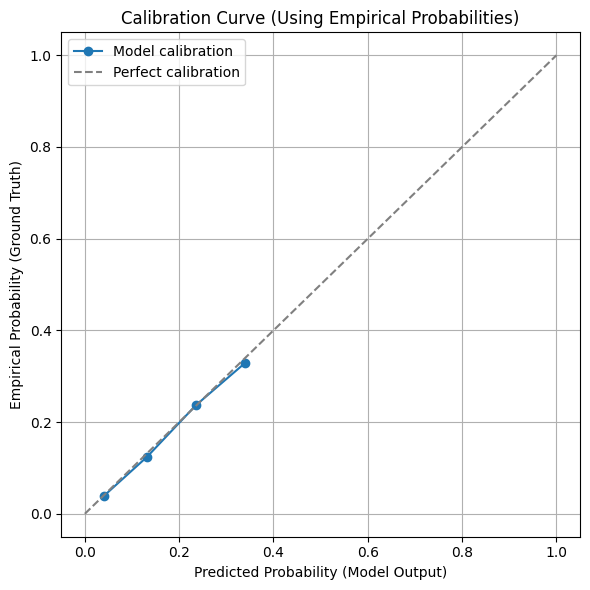

In [22]:
# y_pred and y_true must be flattened
import matplotlib.pyplot as plt
import numpy as np

def manual_calibration_plot(y_pred, y_true, n_bins=10):
    """Create a manual calibration plot for real-valued targets"""
    assert y_pred.shape == y_true.shape

    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_pred, bins) - 1  # bin index per sample

    bin_pred_means = []
    bin_true_means = []
    for i in range(n_bins):
        in_bin = bin_ids == i
        if np.any(in_bin):
            bin_pred_means.append(y_pred[in_bin].mean())
            bin_true_means.append(y_true[in_bin].mean())

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(bin_pred_means, bin_true_means, marker='o', label='Model calibration')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
    plt.xlabel('Predicted Probability (Model Output)')
    plt.ylabel('Empirical Probability (Ground Truth)')
    plt.title('Calibration Curve (Using Empirical Probabilities)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


y_pred = predicted_probs_subset.flatten()
y_true = empirical_subset.flatten()
valid = np.isfinite(y_pred) & np.isfinite(y_true)

manual_calibration_plot(y_pred[valid], y_true[valid], n_bins=10)

In [17]:
import numpy as np
import torch
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Load real empirical firing probabilities ---
dat = np.load('/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/hybrid_neural_responses_reduced.npy')
empirical_probs = dat / 50  # shape: (num_neurons, num_images)

# --- Load model predictions ---
# Assuming you already have these:
# average_probs: (num_neurons,) or (num_neurons, num_images)
# Ideally: predicted_probs: shape (num_neurons, num_images)

# Flatten both arrays for calibration analysis
y_true = empirical_probs.flatten()
y_pred = predicted_probs.flatten()  # sigmoid(model logits)

# Filter to remove invalid entries (e.g., if there are NaNs)
valid = np.isfinite(y_true) & np.isfinite(y_pred)

# --- Calibration curve (Binned) ---
prob_true, prob_pred = calibration_curve(y_true[valid], y_pred[valid], n_bins=10, strategy='uniform')

# --- Plot ---
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Empirical probability')
plt.title('Model Calibration (All Neurons, All Stimuli)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'predicted_probs' is not defined